<h1><center>Super Market Sales Analytics</center></h1>

In [84]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import skew
from prettytable import PrettyTable


# For feature selections and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

# Clustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import silhouetteplot
import scipy.cluster.hierarchy as sch
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

# Importing the DecisionTreeClassifier and LogisticRegressionClassifier for model building
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection


# For Analyzing the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from datetime import datetime

pd.options.mode.chained_assignment = None

In [85]:
#Read Data from the csv file
df = pd.read_csv('Supermarket_Sales_Dataset.csv')
df.head(2)

,Invoice ID,Branch,City,Customer Type,Gender,Product Type,Unit Price,Quantity,Tax,Selling Price,Date,Time,Payment Type,Cost Price,Gross Income,Rating
0,750-67-8428,A,Bangalore,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Debit card,522.83,26.1415,9.1
1,226-31-3081,C,Mysore,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,3.8200,9.6


In [86]:
#Defining class colour
class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

<h2>Objectives</h2>

<h5>1) Which city has a better sale for products in the Electronic Accessories product line? </h5>

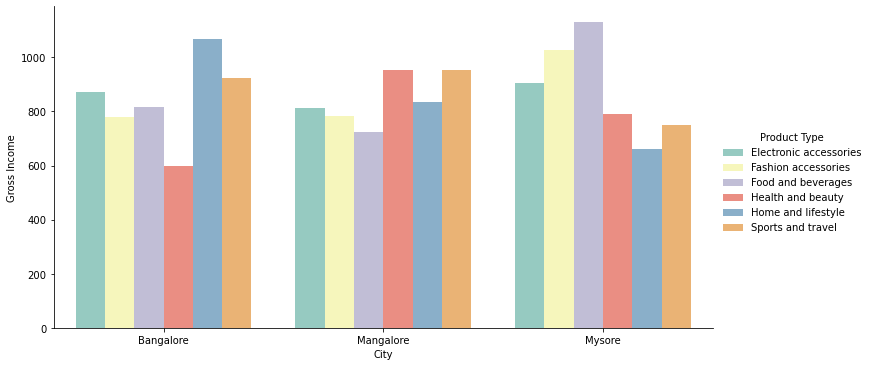

,City,Product Type,Gross Income
12,Mysore,Electronic accessories,903.2845


In [87]:
dfCat=df[['City','Product Type','Gross Income']].groupby(['City','Product Type'],as_index=False).sum()
sns.catplot(data=dfCat, y='Gross Income', x='City',kind='bar', hue='Product Type',height=5,aspect=2,palette="Set3")
plt.show()

dfCat[dfCat['Product Type'] == 'Electronic accessories'].nlargest(1,'Gross Income')

<h5>2) Which payment method is used more often at a particular city, branch and for which product type ? </h5>

In [207]:
dfpm=df[['City','Product Type','Payment Type','Invoice ID']].groupby(['City','Product Type','Payment Type'],as_index=False).count()
dfpm.sort_values(by = ['City', 'Invoice ID'], ascending = [True, False],inplace = True)
dfpm.drop_duplicates(subset="City",inplace = True)                  
dfpm.head()

,City,Product Type,Payment Type,Invoice ID
14,Bangalore,Home and lifestyle,Debit card,26
33,Mangalore,Sports and travel,Cash,26
42,Mysore,Food and beverages,Cash,31


In [ ]:
<h5>3) Which Product type has been more purchased by female customers? </h5>

In [208]:
dfgender=df[['Gender','Product Type','Quantity']].groupby(['Gender','Product Type'],as_index=False).sum()
dfgender[dfgender['Gender'] == 'Female'].nlargest(1,'Quantity')

,Gender,Product Type,Quantity
1,Female,Fashion accessories,530


In [ ]:
<h5>4) In which month does the highest number of home and lifestyle products have been sold ? </h5>

In [9]:
dfm = df[df['Product Type'] == 'Home and lifestyle']
dfm['Date'] = pd.to_datetime(dfm['Date'])
dfm['Month'] = dfm['Date'].dt.month_name(locale = 'English')
dfmtrend = dfm[['Month','Quantity']].groupby([dfm['Month']]).sum()
dfmtrend.sort_values(by = ['Quantity'], ascending = [False],inplace = True)
dfmtrend.head(1)

,Quantity
Month,
March,364


In [ ]:
<h5>5) At what time most of the female customers are purchasing products ? </h5>

In [10]:
dff = df[df['Gender'] == 'Female']
dfft = dff[['Gender','Time','Invoice ID']]
dfft['Invoice ID Count'] = dfft['Invoice ID']
dfff=dfft[['Gender','Time','Invoice ID Count']].groupby(['Gender','Time'],as_index=False).count()
dfff.sort_values(by = ['Invoice ID Count'], ascending = False,inplace = True)
dfff.drop_duplicates(subset="Time",inplace = True)
dfff.head(1)

,Gender,Time,Invoice ID Count
168,Female,14:42,6


<h2>Exploratory Data Analysis</h2>

In [88]:
#Size of the Dataset
print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
print(df.shape)


Size of Dataset:
(1000, 16)


In [89]:
# Attribute and its datatype
ptbl = PrettyTable()

for attribute in df.columns:    
    ptbl.field_names = ["Attribute Name", "Data Type"]
    ptbl.add_row([attribute, df[attribute].dtype])
    
print(ptbl)

+----------------+-----------+
| Attribute Name | Data Type |
+----------------+-----------+
|   Invoice ID   |   object  |
|     Branch     |   object  |
|      City      |   object  |
| Customer Type  |   object  |
|     Gender     |   object  |
|  Product Type  |   object  |
|   Unit Price   |  float64  |
|    Quantity    |   int64   |
|      Tax       |  float64  |
| Selling Price  |  float64  |
|      Date      |   object  |
|      Time      |   object  |
|  Payment Type  |   object  |
|   Cost Price   |  float64  |
|  Gross Income  |  float64  |
|     Rating     |  float64  |
+----------------+-----------+


In [90]:
#Distribution Of Data
distTxt = color.BLUE + color.BOLD + "Data Distribution" + color.END
print(distTxt.center(100))
df.describe()

                                   Data Distribution                                   


,Unit Price,Quantity,Tax,Selling Price,Cost Price,Gross Income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,49.650000,10.00000


In [91]:
columnsList = list(df)
categoricalList = list(df.select_dtypes(include=['object']).columns)
numericalList = list(set(columnsList) - set(categoricalList))

#Character or Numerical Data
print(color.BLUE + color.BOLD + "Categorical Data:" + color.END)
print(categoricalList)
print(color.BLUE + color.BOLD + "\nNumerical Data:" + color.END)
print(numericalList)

Categorical Data:
['Invoice ID', 'Branch', 'City', 'Customer Type', 'Gender', 'Product Type', 'Date', 'Time', 'Payment Type']

Numerical Data:
['Quantity', 'Gross Income', 'Cost Price', 'Rating', 'Unit Price', 'Selling Price', 'Tax ']


Classification of Rating Level:
Medium    498
High      400
Low       102
Name: RatingLevel, dtype: int64


<AxesSubplot:ylabel='RatingLevel'>

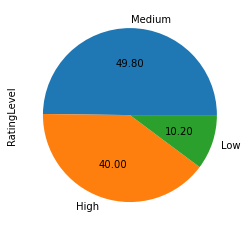

In [92]:
df['RatingLevel'] = pd.cut(x=df['Rating'],
                     bins=[1, 4.5, 7.5, 10],
                     labels=['Low', 'Medium', 'High'])

#Balanced or Imbalanced Dataset
print(color.BLUE + color.BOLD + "Classification of Rating Level:" + color.END)
count = df['RatingLevel'].value_counts()
print(count)
count.plot.pie(autopct='%.2f')

<h2>Data Visualization</h2>

In [ ]:
#Count Plots (for categorical attributes)

plt.rcParams["figure.figsize"] = [14.00, 4.0]
plt.rcParams["figure.autolayout"] = True

index = 0
graphsInARow = 4

for attr in categoricalList:
    
    if (index % graphsInARow == 0):
        f, ax = plt.subplots(1, graphsInARow)
        
    sns.countplot(x=attr, data=df, ax = ax[index % graphsInARow])
    index = index + 1
    
    if (index % graphsInARow == 0):
        plt.show()

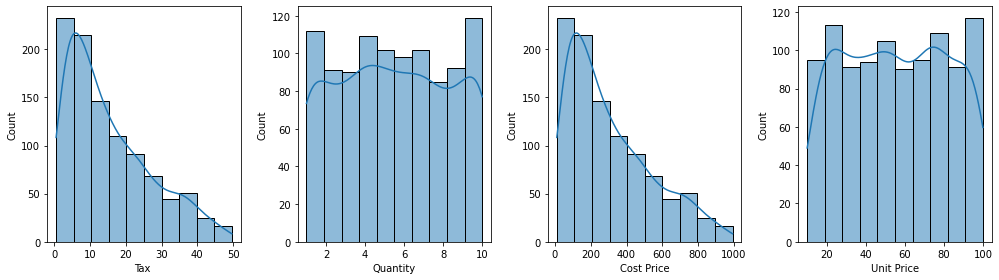

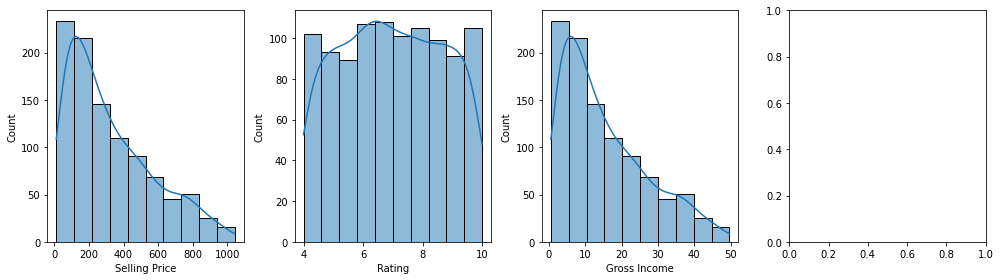

In [14]:
#Histogram Distribution (for Continuous Attributes)
plt.rcParams["figure.figsize"] = [14.00, 4.0]
plt.rcParams["figure.autolayout"] = True

index = 0
graphsInARow = 4

for attr in numericalList:
    if (index % graphsInARow == 0):
        f, ax = plt.subplots(1, graphsInARow)
    sns.histplot(data=df[attr], bins=10, kde=True, ax = ax[index % graphsInARow])
    index = index + 1
    if (index % graphsInARow == 0):
        plt.show()

                                         Correlation Using HeatMap                                         


<AxesSubplot:>

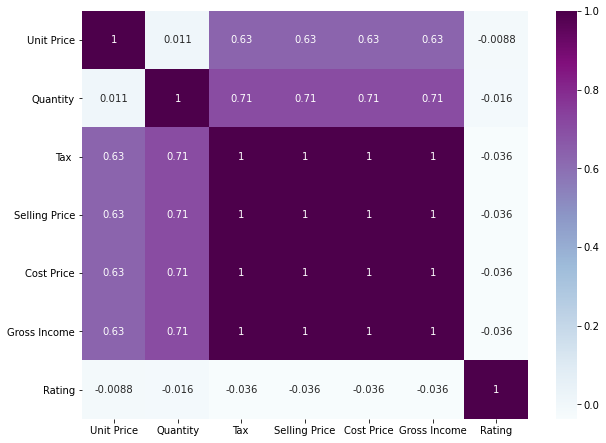

In [93]:
#Correlation of the features in the dataset
corr = df.corr()

corrTxt = color.BLUE + color.BOLD + "Correlation Using HeatMap" + color.END
print(corrTxt.center(120))

#Visualizing correlation using Heatmap
plt.figure(figsize=(10,7.5))
sns.heatmap(corr, annot=True, cmap='BuPu')

<h2>Data Wrangling</h2>

In [94]:
#Count of NaN/Null values from dataset
print(color.BLUE + color.BOLD + "\nCount of NaN/Null values for each feature:" + color.END)
print(df.isna().sum())


Count of NaN/Null values for each feature:
Invoice ID       0
Branch           0
City             0
Customer Type    0
Gender           0
Product Type     0
Unit Price       0
Quantity         0
Tax              0
Selling Price    0
Date             0
Time             0
Payment Type     0
Cost Price       0
Gross Income     0
Rating           0
RatingLevel      0
dtype: int64


In [95]:
# Checking for duplicates
df.duplicated().sum()

0

In [96]:
# Dropping the attributes that has a unique number(number assignment) for all the rows or attributes derivable from other features 
df=df.drop(['Invoice ID','Branch'], axis=1)

In [97]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
def featSelectFilter(attData1):
    # Create correlation matrix
    corr_matrix = corr.abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

    # Get features with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

    print(color.BLUE + color.BOLD + 'Features removed since correlation is higher:' + color.END)
    print(to_drop)

    # Drop features 
    attData1.drop(list(to_drop), axis=1, inplace=True)
    
    #Size of the Dataset
    print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
    print(attData1.shape)
    
    return attData1

In [98]:
#Transform the non numerical data into numerical
def transformToNumerical(attData1):
    for column in attData1.columns:
        if attData1[column].dtype == 'int64': #If Column data type is Int i.e, numerical continue
            continue
        attData1[column] = LabelEncoder().fit_transform(attData1[column].astype(str)) #If Column data type is not Int, encode and transform to Numerical
    
    print(color.BLUE + color.BOLD + 'After Encoding to numerical(First 10 records):\n' + color.END)
    print(attData1.head(10)) #Print first 10 records of dataset after encoding
    
    return attData1

In [99]:
#Split the entire dataset to Train and Test 
def splitTrainTest(attData1, attData2):
#     X = attData1.iloc[:, 1:attData2.shape[1]] #From the second column, all the columns taken for train dataset
#     Y = attData1.iloc[:, 0] #First Column 'Attrition' taken as test dataset
    
    #Splitting the dataset
    X = attData1.iloc[:, 0:attData2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    Y = attData1.iloc[:, -1]
    
    #Split the data into 80% training and 20% testing
    return train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [100]:
#Standardization or z-score normalization
def tranformationZScore(X_train, X_test):
    scaler = StandardScaler()
    
    # Fit on training set only.
    scaler.fit(X_train)
    
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(color.BLUE + color.BOLD + 'Standardized or z-score Normalized Train and Test Dataset:\n' + color.END)
    print(X_train)
    print(X_test)
    
    return X_train, X_test

In [101]:
#Dimensionality Reduction using PCA
def dimReductionPCA(X_train, X_test):
    # Make an instance of the Model
    pca = PCA(.95)

    pca.fit(X_train)

    X_train = pca.transform(X_train) #PCA transformation on Train Set
    X_test = pca.transform(X_test) #PCA transformation on Test Set

    #How much information (variance) attributed to each of the principal components
    explained_variance = pca.explained_variance_ratio_
    print(color.BLUE + color.BOLD + 'Variance attributed to each of the principal components:' + color.END)
    print(explained_variance)
    
    return X_train, X_test

In [102]:
#Handling the Dataset Imbalance Using Hybridization: SMOTE + Tomek Links
def handleClassImbalance(X_train, Y_train):
    
    counter = Counter(Y_train) #Before Sampling, count of Y_train
    print(color.BLUE + color.BOLD + 'Before Sampling:' + color.END)
    print(counter)

    #Oversampling the train dataset using SMOTE + Tomek
    smtom = SMOTETomek(random_state=0)  #To get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE
    X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, Y_train) #Fit the resampled model

    counter = Counter(y_train_smtom) #After Sampling, Count of y_train_smtom
    print(color.BLUE + color.BOLD + 'After Sampling:' + color.END)
    print(counter)
    
    return X_train_smtom, y_train_smtom

In [103]:
#Train the model using Random Forest classifier - This meta estimator fits a number of decision tree classifiers on sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
def randomForestModel(X_train_smtom, y_train_smtom):
    #Number of trees given as '10' with criterion 'entropy' and seed for random generator is set as '0' 
    randomforest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) 
    randomforest.fit(X_train_smtom, y_train_smtom)

    return randomforest

In [104]:
#Plotting top 6 features that help in predicting using the Random Forest Built-in Feature Importance 
def importantFeatures(randomforest, attData1):
    #Determine the feature importance values
    importances = randomforest.feature_importances_ 
    
    #Create a dictionary with the importances values
    important_features_dict = {}
    for idx, val in enumerate(importances): 
        important_features_dict[idx] = val
    
    #Sort the feature importances in descending order
    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)[1:]

    important_features = attData1.columns[important_features_list]

    #Visualize the top 6 feature importance using bar chart
    feat_importances = pd.Series(importances[important_features_list], index=important_features)
    feat_importances.nlargest(6).plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.title('Top 6 Features With Higher Random Forest Feature Importance')
    plt.show()

In [132]:
#Create Machine Learning models – Logistic regression and Decision tree to predict
def mlPredict(X_train_smtom, y_train_smtom, Y_test):
    cv_dataFrames = []
    
    # Prepare Machine Learning models – Logistic regression and Decision tree
    models = []
    
    #Parametric Supervised learning model based on probability
    models.append(('Logistic Regression(LR)', LogisticRegression()))
    #Non-Parametric Supervised learning model by learning simple decision rules inferred from the data features
    models.append(('Decision Tree(CART)', DecisionTreeClassifier())) 

    results = []
    mNames = [] #List for collecting model names
    
    #List of scoring metrics for comparison of models
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'] 
    
    targ_names = ['Low', 'Medium', 'High'] #List of target values
    
    for mName, model in models: #Looping through each of the models
                   
            #Fit the model and predict the label of test set
            ml = model.fit(X_train_smtom, y_train_smtom) 
            y_pred = ml.predict(X_test)
            
            print(color.BLUE + color.BOLD + mName + color.END)
            
            #Number of correct and incorrect predictions compared wih Actual class and Predicted class
            cm = confusion_matrix(Y_test, y_pred)
            
            cmTitle = "Confusion Matrix of" + mName
            plt.figure(figsize=(12,6))
            plt.title(cmTitle)
            sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
            plt.ylabel("Actual Values")
            plt.xlabel("Predicted Values")
            plt.savefig('confusion_matrix.png')
            
            #Accuracy determines how often is classifier correct, (TP+TN)/Total
            print(color.BOLD + "\nAccuracy:" + color.END)
            print(round(accuracy_score(Y_test, y_pred) * 100, 2),"%")
            
            #Return the list of scores calculated for each cv='10' folds, estimator object implementing ‘fit’ and n_jobs='-1' means using all processors
            cross_val_lr = cross_val_score(estimator = model, X = X_train_smtom, y = y_train_smtom, cv = 10, n_jobs = -1)
            print(color.BOLD + "\nCross Validation Accuracy:" + color.END)
            print(round(cross_val_lr.mean() * 100 , 2),"%")
            
            #Report showing the main classification metrics with the target names 'Yes' and 'No'
            print(color.BOLD + "\nClassification Report:" + color.END)
            print(classification_report(Y_test, y_pred, target_names=targ_names))
            
#             #Get False Positive Rates and True Postive rates for the Classifiers
#             #By roc_curve module by passing the test dataset and the predicted data through it
#             print(color.BOLD + "\nReceiver Operating Characteristic(ROC):" + color.END)
#             false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred)
            
#             #Ploting ROC Curves with False Positive Rate on X-axis and True Positive Rate on Y-axis
#             title = 'Receiver Operating Characteristic(ROC) - ' + mName
#             plt.subplots(1, figsize=(10,10))
#             plt.title(title)
#             plt.plot(false_positive_rate1, true_positive_rate1)
#             plt.plot([0, 1], ls="--")
#             plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
#             plt.ylabel('True Positive Rate')
#             plt.xlabel('False Positive Rate')
            

In [127]:
#Comparison of Performance of Logistic Regression and Decision tree models
def ml_ModelsComparison(result):
    mlValues = []
    
    #Iterating through result values and append the values of each models to mlValues[]
    for model in list(set(result.model.values)): 
        m_dataFrame = result.loc[result.model == model]
        mlValue = m_dataFrame.sample(n=30, replace=True)
        mlValues.append(mlValue)

    m_dataFrame = pd.concat(mlValues, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    
    #Massage a DataFrame into a format where identifier variable is 'model', variable column 'metrics' and value column 'values'
    perf_results = pd.melt(m_dataFrame,id_vars=['model'],var_name='metrics', value_name='values')
    
    tym_metrics = ['fit_time','score_time'] # Fit time Metrics
    
    #Performance Metrics
    perf_results_nofit = perf_results.loc[~perf_results['metrics'].isin(tym_metrics)] # Get dataframe without fit data
    perf_results_nofit = perf_results_nofit.sort_values(by='values') #Sort the performance result on its values

    #Visualization of Comparison of LR and CART Model using BoxPlot
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.0)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=perf_results_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of LR and CART Model by Classification Metric')

    return perf_results_nofit, m_dataFrame

Logistic Regression(LR)

Accuracy:
30.5 %

Cross Validation Accuracy:
38.36 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.36      0.20      0.25        76
      Medium       0.16      0.55      0.24        29
        High       0.55      0.32      0.40        95

    accuracy                           0.30       200
   macro avg       0.35      0.35      0.30       200
weighted avg       0.42      0.30      0.32       200

Decision Tree(CART)

Accuracy:
34.5 %

Cross Validation Accuracy:
59.38 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.33      0.30      0.32        76
      Medium       0.19      0.31      0.24        29
        High       0.45      0.39      0.42        95

    accuracy                           0.34       200
   macro avg       0.32      0.33      0.32       200
weighted avg       0.36      0.34      0.35       200



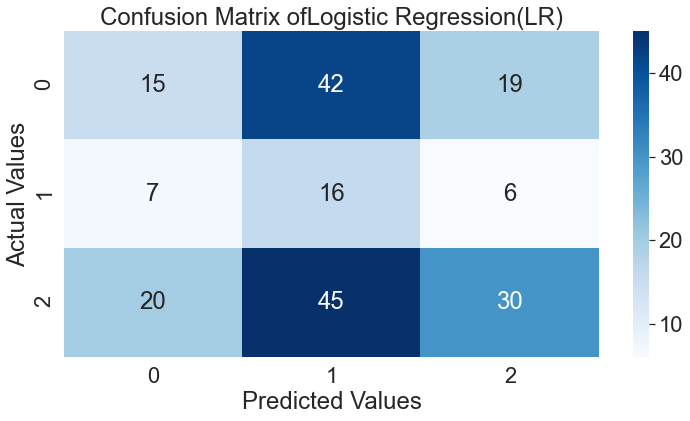

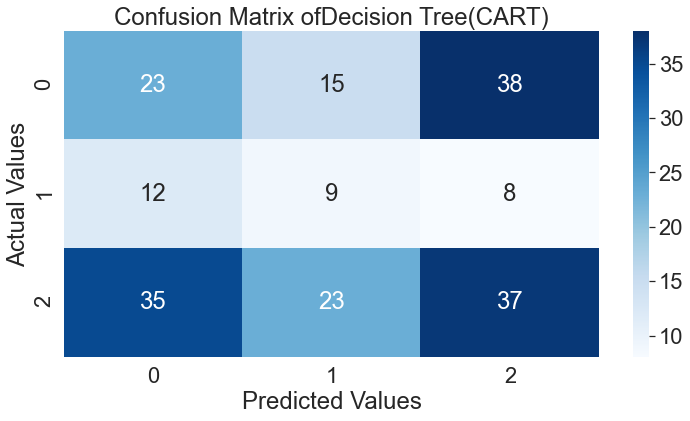

In [133]:
mlPredict(X_train_smtom, y_train_smtom, Y_test) 

In [ ]:
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=chi2, k=5)
    fs.fit_transform(X_train, y_train)
    return fs


def featSelWrapper(attData2):
    #Splitting the dataset
    X = attData2.iloc[:, 0:attData2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    y = attData2.iloc[:, -1]

    fs = select_features(X, y)

    for i in range(len(fs.scores_)):
        print('Train Feature %d: %f' % (i, fs.scores_[i]))
        print('Train Feature',list(X.columns)[i])


    selected_features_chi2 = list(X.columns[fs.get_support(indices=True)])
    print(selected_features_chi2)

In [107]:
#Wrapper Method (Greedy Algorithms)
#Removes (backward selection) features to form a feature subset in a greedy fashion.
#At each stage, this estimator chooses the best feature to remove based on the cross-validation score of the estimator "Linear Regression"
def featSelWrapper(attData2):
    #Splitting the dataset
    X = attData2.iloc[:, 1:attData2.shape[1]]
    Y = attData2.iloc[:, 0]
    
    #Sequential backward selection(sbs)
    sbs = SFS(LinearRegression(),
             k_features=25, #25 features selected
             forward=False, #Backward selection
             floating=False, #Sequential
             cv=0) #Cross Validation set to '0'
    
    sbs.fit(X, Y) #Fit the model
    
    #List the features after the sbs method
    list_features = list(sbs.k_feature_names_)
    print(list_features)
    
    return list_features

In [108]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
dfFilter = df #Create a copy of attData dataset
dfFilter = featSelectFilter(dfFilter)

Features removed since correlation is higher:
['Selling Price', 'Cost Price', 'Gross Income']

Size of Dataset:
(1000, 12)


In [109]:
#Feature Encoding (To Numerical)
dfFilter = transformToNumerical(dfFilter)

After Encoding to numerical(First 10 records):

   City  Customer Type  Gender  Product Type  Unit Price  Quantity  Tax   \
0     0              0       0             3         670         7   466   
1     2              1       0             0          50         5   568   
2     0              1       1             4         370         7   233   
3     0              0       1             3         501         8   418   
4     0              1       1             5         782         7   580   
5     2              1       1             0         773         7   510   
6     0              0       0             0         595         6   366   
7     2              1       0             4         653        10   645   
8     0              0       0             3         272         2   550   
9     1              0       0             2         463         3   910   

   Date  Time  Payment Type  Rating  RatingLevel  
0    26   146             2      52            0  
1    87    23

In [110]:
#Splitting the Dataset to Train and Test
X_train, X_test, Y_train, Y_test = splitTrainTest(dfFilter, dfFilter)

In [111]:
#Normalization of Dataset using z-score normalization
X_train, X_test = tranformationZScore(X_train, X_test)

Standardized or z-score Normalized Train and Test Dataset:

[[-1.19986008 -0.99501244  1.00250313 ... -1.45864926  0.78487875
  -1.22519798]
 [ 0.02448694 -0.99501244  1.00250313 ...  0.29594087  0.16348017
  -0.0210722 ]
 [-1.19986008  1.00501256  1.00250313 ...  0.29594087  0.20400617
  -1.22519798]
 ...
 [-1.19986008  1.00501256 -0.99750312 ... -1.02974945  0.8997024
  -0.0210722 ]
 [-1.19986008 -0.99501244 -0.99750312 ...  1.38768583  0.49444246
   1.18305358]
 [ 0.02448694 -0.99501244 -0.99750312 ... -1.10773123  1.19013869
   1.18305358]]
[[ 0.02448694  1.00501256  1.00250313 ...  0.02300463  0.96724572
   1.18305358]
 [-1.19986008 -0.99501244 -0.99750312 ... -1.14672212 -0.90370434
  -1.22519798]
 [-1.19986008 -0.99501244  1.00250313 ... -1.06874034  0.1702345
  -1.22519798]
 ...
 [-1.19986008  1.00501256  1.00250313 ...  1.11474959 -0.12020179
  -0.0210722 ]
 [ 0.02448694 -0.99501244  1.00250313 ...  1.58264029  0.04190219
   1.18305358]
 [ 0.02448694 -0.99501244 -0.99750312 ..

In [112]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.12021028 0.11348524 0.11187242 0.10546226 0.1022403  0.09960212
 0.09119172 0.08896258 0.08430072 0.08267235]


In [113]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({2: 403, 0: 324, 1: 73})
After Sampling:
Counter({1: 403, 2: 329, 0: 329})


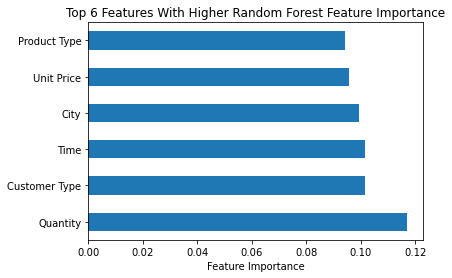

In [114]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFilter)

In [ ]:
FE1_X_test, FE1_Y_

In [ ]:
#Feature Selection 2 - Wrapper Method(Sequential Backward Selection using Linear Regression)
attDataWrap = attData #Create a copy of attData dataset
attDataWrap = transformToNumerical(attDataWrap) #Feature Encoding (To Numerical)
sel_features = featSelWrapper(attDataWrap) #Wrapper Method

In [ ]:
#Splitting the Dataset to Train and Test
X_train, X_test, Y_train, Y_test = splitTrainTest(attDataWrap, attDataWrap[sel_features])

In [ ]:
#Normalization of Dataset using z-score normalization
X_train, X_test = tranformationZScore(X_train, X_test)

In [ ]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

In [ ]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

In [ ]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, attDataWrap)

In [ ]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

In [ ]:
#Machine Learning models – Logistic regression and Decision tree to predict attrition and Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [ ]:
#Comparison of Performance metrics
metricValues = list(set(perf_results_nofit.metrics.values))
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean]) #aggregate metric values with standard deviation and mean

<h2> Feature Selection </h2>

In [11]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)

dfFilter = df #Create a copy of attData dataset

# Create correlation matrix
corr_matrix = corr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Get features with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

print(color.BLUE + color.BOLD + 'Features removed since correlation is higher:' + color.END)
print(to_drop)

# Drop features 
dfFilter.drop(list(to_drop), axis=1, inplace=True)

#Size of the Dataset
print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
print(dfFilter.shape)


Features removed since correlation is higher:
['Cost Price', 'Gross Income']

Size of Dataset:
(1000, 13)


In [12]:
#Transform the non numerical data into numerical
for column in dfFilter.columns:
    if dfFilter[column].dtype == 'int64': #If Column data type is Int i.e, numerical continue
        continue
    dfFilter[column] = LabelEncoder().fit_transform(dfFilter[column].astype(str)) #If Column data type is not Int, encode and transform to Numerical

print(color.BLUE + color.BOLD + 'After Encoding to numerical(First 10 records):\n' + color.END)
print(dfFilter.head(10)) #Print first 10 records of dataset after encoding


After Encoding to numerical(First 10 records):

   City  Customer Type  Gender  Product Type  Unit Price  Quantity  Tax   \
0     0              0       0             3         635         7   408   
1     2              1       0             0         446         5   521   
2     0              1       1             4         302         7   150   
3     0              0       1             3         448         8   355   
4     0              1       1             5         759         7   535   
5     2              1       1             0         749         7   458   
6     0              0       0             0         551         6   297   
7     2              1       0             4         616        10   607   
8     0              0       0             3         193         2   502   
9     1              0       0             2         405         3   902   

   Selling Price  Date  Time  Payment Type  Rating  RatingLevel  
0            650    19    53             2      4

In [32]:
def select_features(X_train, y_train):
	fs = SelectKBest(score_func=chi2, k=5)
	fs.fit_transform(X_train, y_train)
	return fs



#Splitting the dataset
X = dfFilter.iloc[:, 0:dfFilter.shape[1]]
X = X.drop(['RatingLevel','Rating'], axis=1)
y = dfFilter.iloc[:, -1]

fs = select_features(X, y)

for i in range(len(fs.scores_)):
    print('Train Feature %d: %f' % (i, fs.scores_[i]))
    print('Train Feature',list(X.columns)[i])
    

selected_features_chi2 = list(X.columns[fs.get_support(indices=True)])
print(selected_features_chi2)


Train Feature 0: 0.416175
Train Feature City
Train Feature 1: 0.348567
Train Feature Customer Type
Train Feature 2: 2.740330
Train Feature Gender
Train Feature 3: 1.751667
Train Feature Product Type
Train Feature 4: 6.670035
Train Feature Unit Price
Train Feature 5: 0.906830
Train Feature Quantity
Train Feature 6: 532.192637
Train Feature Tax 
Train Feature 7: 1296.726587
Train Feature Selling Price
Train Feature 8: 6.010800
Train Feature Date
Train Feature 9: 370.725544
Train Feature Time
Train Feature 10: 0.176433
Train Feature Payment Type
['Unit Price', 'Tax ', 'Selling Price', 'Date', 'Time']


In [33]:
def select_features(X_train, y_train):
	fs = SelectKBest(score_func=mutual_info_classif, k=5)
	fs.fit_transform(X_train, y_train)
	return fs

#Splitting the dataset
X = dfFilter.iloc[:, 0:dfFilter.shape[1]]
X = X.drop(['RatingLevel','Rating'], axis=1)
y = dfFilter.iloc[:, -1]

fs = select_features(X, y)


for i in range(len(fs.scores_)):
    print('Train Feature %d: %f' % (i, fs.scores_[i]))
    print('Train Feature',list(X.columns)[i])
    

selected_features_mutual_info = list(X.columns[fs.get_support(indices=True)])
print(selected_features_mutual_info)

Train Feature 0: 0.011788
Train Feature City
Train Feature 1: 0.000000
Train Feature Customer Type
Train Feature 2: 0.011270
Train Feature Gender
Train Feature 3: 0.000000
Train Feature Product Type
Train Feature 4: 0.021130
Train Feature Unit Price
Train Feature 5: 0.014696
Train Feature Quantity
Train Feature 6: 0.022153
Train Feature Tax 
Train Feature 7: 0.017732
Train Feature Selling Price
Train Feature 8: 0.000000
Train Feature Date
Train Feature 9: 0.001537
Train Feature Time
Train Feature 10: 0.000000
Train Feature Payment Type
['City', 'Unit Price', 'Quantity', 'Tax ', 'Selling Price']


In [34]:
final_features=selected_features_chi2+selected_features_mutual_info
final_features=list(set(final_features))
final_features.append('Quantity')

In [35]:
print(final_features)

['City', 'Quantity', 'Date', 'Unit Price', 'Selling Price', 'Time', 'Tax ', 'Quantity']


In [14]:
df.head(10)

,City,Customer Type,Gender,Product Type,Unit Price,Quantity,Tax,Selling Price,Date,Time,Payment Type,Rating,RatingLevel
0,0,0,0,3,635,7,408,650,19,53,2,48,0
1,2,1,0,0,446,5,521,868,86,146,0,53,0
2,0,1,1,4,302,7,150,394,80,63,1,29,2
3,0,0,1,3,448,8,355,584,11,429,2,40,0
4,0,1,1,5,759,7,535,730,53,212,2,6,2
5,2,1,1,0,749,7,458,716,74,327,2,12,1
6,0,0,0,0,551,6,297,516,43,129,2,11,2
7,2,1,0,4,616,10,607,848,42,481,2,36,0
8,0,0,0,3,193,2,502,828,1,270,1,27,2
9,1,0,0,2,405,3,902,71,38,67,1,13,2


In [18]:
#Splitting the dataset
X = dfFilter.iloc[:, 0:dfFilter.shape[1]]
X = X.drop(['RatingLevel','Rating'], axis=1)
Y = dfFilter.iloc[:, -1]
print(X.head(2))

   City  Customer Type  Gender  Product Type  Unit Price  Quantity  Tax   \
0     0              0       0             3         635         7   408   
1     2              1       0             0         446         5   521   

   Selling Price  Date  Time  Payment Type  
0            650    19    53             2  
1            868    86   146             0  


In [19]:
#Feature Selection 2 - Wrapper Method(Sequential Backward Selection using Linear Regression)

#Removes (backward selection) features to form a feature subset in a greedy fashion.
#At each stage, this estimator chooses the best feature to remove based on the cross-validation score of the estimator "Linear Regression"

#Sequential backward selection(sbs)
sbs = SFS(LinearRegression(),
         k_features=10, #12 features selected
         forward=False, #Backward selection
         floating=False, #Sequential
         cv=0) #Cross Validation set to '0'

sbs.fit(X, Y) #Fit the model

#List the features after the sbs method
list_features = list(sbs.k_feature_names_)
dfFinal = df[list_features]
print(dfFinal.head(2))

   City  Customer Type  Gender  Product Type  Unit Price  Quantity  Tax   \
0     0              0       0             3         635         7   408   
1     2              1       0             0         446         5   521   

   Selling Price  Date  Payment Type  
0            650    19             2  
1            868    86             0  


In [38]:
X = df[final_features]
Y = df['RatingLevel']
Y=Y.astype('int')

<h2> Feature Engineering </h2>

In [39]:
#Splitting the Dataset to Train and Test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [40]:
# FE1 - Standardization or z-score normalization
def tranformationZScore(X_train, X_test):
    scaler = StandardScaler()
    
    # Fit on training set only.
    scaler.fit(X_train)
    
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print(color.BLUE + color.BOLD + 'Standardized or z-score Normalized Train and Test Dataset:\n' + color.END)
    print(X_train)
    print(X_test)
    
    return X_train, X_test

In [41]:
#Handling the Dataset Imbalance Using Hybridization: SMOTE + Tomek Links
def handleClassImbalance(X_train, Y_train):
    
    counter = Counter(Y_train) #Before Sampling, count of Y_train
    print(color.BLUE + color.BOLD + 'Before Sampling:' + color.END)
    print(counter)

    #Oversampling the train dataset using SMOTE + Tomek
    smtom = SMOTETomek(random_state=0)  #To get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE
    X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, Y_train) #Fit the resampled model

    counter = Counter(y_train_smtom) #After Sampling, Count of y_train_smtom
    print(color.BLUE + color.BOLD + 'After Sampling:' + color.END)
    print(counter)
    
    return X_train_smtom, y_train_smtom

In [42]:
#Train the model using Random Forest classifier - This meta estimator fits a number of decision tree classifiers on sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
def randomForestModel(X_train_smtom, y_train_smtom):
    #Number of trees given as '10' with criterion 'entropy' and seed for random generator is set as '0' 
    randomforest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) 
    randomforest.fit(X_train_smtom, y_train_smtom)

    return randomforest

In [43]:
#Plotting top 6 features that help in predicting using the Random Forest Built-in Feature Importance 
def importantFeatures(randomforest, df1):
    #Determine the feature importance values
    importances = randomforest.feature_importances_ 
    
    #Create a dictionary with the importances values
    important_features_dict = {}
    for idx, val in enumerate(importances): 
        important_features_dict[idx] = val
    
    #Sort the feature importances in descending order
    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)[1:]

    important_features = df1.columns[important_features_list]

    #Visualize the top 6 feature importance using bar chart
    feat_importances = pd.Series(importances[important_features_list], index=important_features)
    feat_importances.nlargest(6).plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.title('Top 6 Features With Higher Random Forest Feature Importance')
    plt.show()

In [44]:
#Create Machine Learning models – Logistic regression and Decision tree to predict
def mlPredict(X_train_smtom, y_train_smtom, Y_test):
    cv_dataFrames = []
    
    # Prepare Machine Learning models – Logistic regression and Decision tree
    models = []
    
    #Parametric Supervised learning model based on probability
    models.append(('Logistic Regression(LR)', LogisticRegression()))
    #Non-Parametric Supervised learning model by learning simple decision rules inferred from the data features
    models.append(('Decision Tree(CART)', DecisionTreeClassifier())) 

    results = []
    mNames = [] #List for collecting model names
    
    #List of scoring metrics for comparison of models
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'] 
    
    targ_names = ['Yes', 'No'] #List of target values
    
    for mName, model in models: #Looping through each of the models
        
            #Split the dataset into '5' folds and Each fold is used once as a validation while the '5 - 1' remaining folds form the training set
            #Shuffle is set to 'True' to shuffle the data before splitting into batches
            #Random_state affects the ordering of the indices, which controls the randomness of each fold
            kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210) 
            
            #Evaluate metrics by cross-validation
            cv_res = model_selection.cross_validate(model, X_train_smtom, y_train_smtom, cv=kfold, scoring=scoring)
            
            #Fit the model and predict the label of test set
            ml = model.fit(X_train_smtom, y_train_smtom) 
            y_pred = ml.predict(X_test)
            
            print(color.BLUE + color.BOLD + mName + color.END)
            
            #Number of correct and incorrect predictions compared wih Actual class and Predicted class
            cm = confusion_matrix(Y_test, y_pred)

            TN = cm[0][0] #True Negative(Model predicted No and the Actual is also No, classifier is getting things right)
            TP = cm[1][1] #True Positive(Model predicted Yes and the Actual is also Yes, classifier is getting things right)
            FN = cm[1][0] #False Negative(Model predicted No and the Actual is Yes, classifier is getting things wrong i.e, mislabelling)
            FP = cm[0][1] #False Positive(Model predicted Yes and the Actual is No, classifier is getting things wrong i.e, mislabelling)

            print(color.BOLD + "\nConfusion Matrix:" + color.END)
            
            column_names = ['Predicted Yes', 'No']
            row_names    = ['Actual Yes', 'No']
            
            cm_df = pd.DataFrame(cm, columns=column_names, index=row_names)
            
            print(cm_df)
            
            #Accuracy determines how often is classifier correct, (TP+TN)/Total
            print(color.BOLD + "\nAccuracy:" + color.END)
            print(round(accuracy_score(Y_test, y_pred) * 100, 2),"%")
            
            #Return the list of scores calculated for each cv='10' folds, estimator object implementing ‘fit’ and n_jobs='-1' means using all processors
            cross_val_lr = cross_val_score(estimator = model, X = X_train_smtom, y = y_train_smtom, cv = 10, n_jobs = -1)
            print(color.BOLD + "\nCross Validation Accuracy:" + color.END)
            print(round(cross_val_lr.mean() * 100 , 2),"%")
            
            #Report showing the main classification metrics with the target names 'Yes' and 'No'
            print(color.BOLD + "\nClassification Report:" + color.END)
            print(classification_report(Y_test, y_pred, target_names=targ_names))
            
            #Get False Positive Rates and True Postive rates for the Classifiers
            #By roc_curve module by passing the test dataset and the predicted data through it
            print(color.BOLD + "\nReceiver Operating Characteristic(ROC):" + color.END)
            false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred)
            
            #Ploting ROC Curves with False Positive Rate on X-axis and True Positive Rate on Y-axis
            title = 'Receiver Operating Characteristic(ROC) - ' + mName
            plt.subplots(1, figsize=(10,10))
            plt.title(title)
            plt.plot(false_positive_rate1, true_positive_rate1)
            plt.plot([0, 1], ls="--")
            plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            
            results.append(cv_res) #Appending the cross validation metrics
            mNames.append(mName) #Appending each of the model names

            dataFrame = pd.DataFrame(cv_res) #Create data frame of cross validation results
            dataFrame['model'] = mName #Add the model name to dataframe
            cv_dataFrames.append(dataFrame) #Append each of the data frames
            
            result = pd.concat(cv_dataFrames, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    return result

In [45]:
#Comparison of Performance of Logistic Regression and Decision tree models
def ml_ModelsComparison(result):
    mlValues = []
    
    #Iterating through result values and append the values of each models to mlValues[]
    for model in list(set(result.model.values)): 
        m_dataFrame = result.loc[result.model == model]
        mlValue = m_dataFrame.sample(n=30, replace=True)
        mlValues.append(mlValue)

    m_dataFrame = pd.concat(mlValues, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    
    #Massage a DataFrame into a format where identifier variable is 'model', variable column 'metrics' and value column 'values'
    perf_results = pd.melt(m_dataFrame,id_vars=['model'],var_name='metrics', value_name='values')
    
    tym_metrics = ['fit_time','score_time'] # Fit time Metrics
    
    #Performance Metrics
    perf_results_nofit = perf_results.loc[~perf_results['metrics'].isin(tym_metrics)] # Get dataframe without fit data
    perf_results_nofit = perf_results_nofit.sort_values(by='values') #Sort the performance result on its values

    #Visualization of Comparison of LR and CART Model using BoxPlot
    plt.figure(figsize=(20, 12))
    sns.set(font_scale=2.0)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=perf_results_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of LR and CART Model by Classification Metric')

    return perf_results_nofit, m_dataFrame

In [46]:
#Normalization of Dataset using z-score normalization
X_train, X_test = tranformationZScore(X_train, X_test)

Standardized or z-score Normalized Train and Test Dataset:

[[-1.19986008  1.53272506  0.87875189 ...  0.32482323  0.18704919
   1.53272506]
 [ 0.02448694 -1.53357681  0.143961   ... -0.36991297  0.0586957
  -1.53357681]
 [-1.19986008 -0.17077598  0.143961   ... -0.32223499 -0.91956602
  -0.17077598]
 ...
 [-1.19986008 -1.53357681 -1.32562076 ...  0.45423487 -1.703563
  -1.53357681]
 [-1.19986008 -0.85217639  1.34283034 ...  0.00469969  1.07164756
  -0.85217639]
 [ 0.02448694  0.16992423 -1.40296717 ...  0.78116955  1.18265598
   0.16992423]]
[[ 0.02448694  1.53272506 -0.16542463 ...  0.5291574   1.51915026
   1.53272506]
 [-1.19986008  1.19202485 -1.44164038 ... -1.56186231 -0.62816891
   1.19202485]
 [-1.19986008 -0.51147619 -1.36429397 ... -0.36310183 -1.65499682
  -0.51147619]
 ...
 [-1.19986008 -1.53357681  1.0334447  ... -0.68322537 -1.70009399
  -1.53357681]
 [ 0.02448694  1.19202485  1.53619636 ... -0.50613575 -1.13117583
   1.19202485]
 [ 0.02448694 -0.51147619  1.07211791 ...

In [47]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({2: 403, 0: 324, 1: 73})
After Sampling:
Counter({1: 395, 0: 322, 2: 318})


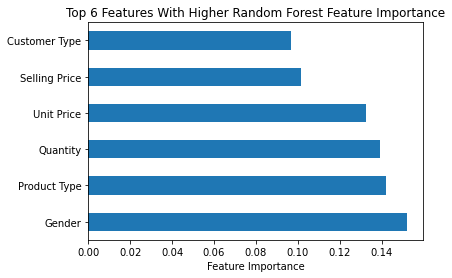

In [48]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFinal)

In [50]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

C:\Users\802295\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\802295\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\802295\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\802295\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\802295\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan

Logistic Regression(LR)

Confusion Matrix:


ValueError: Shape of passed values is (3, 3), indices imply (2, 2)

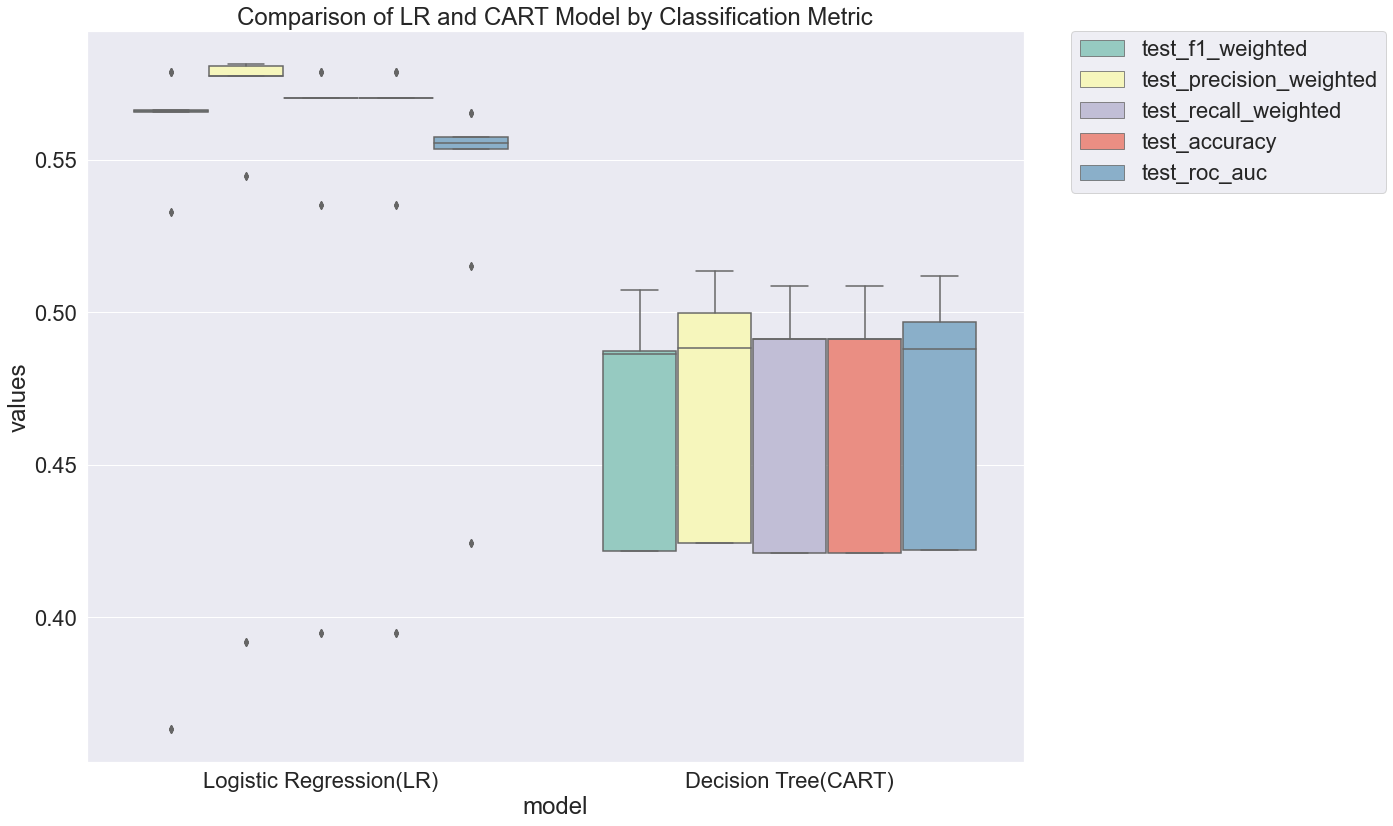

In [44]:
#Machine Learning models – Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [45]:
#Splitting the Dataset to Train and Test

X = dfFinal.iloc[:, 1:dfFinal.shape[1]] #From the second column, all the columns taken for train dataset
Y = dfFinal.iloc[:, 0] #First Column 'Attrition' taken as test dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [46]:
# FE2 - Dimensionality Reduction using PCA
def dimReductionPCA(X_train, X_test):
    # Make an instance of the Model
    pca = PCA(.95)

    pca.fit(X_train)

    X_train = pca.transform(X_train) #PCA transformation on Train Set
    X_test = pca.transform(X_test) #PCA transformation on Test Set

    #How much information (variance) attributed to each of the principal components
    explained_variance = pca.explained_variance_ratio_
    print(color.BLUE + color.BOLD + 'Variance attributed to each of the principal components:' + color.END)
    print(explained_variance)
    
    return X_train, X_test

In [49]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.76135592 0.22862465]


In [50]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0: 402, 1: 398})
After Sampling:
Counter({0: 291, 1: 291})


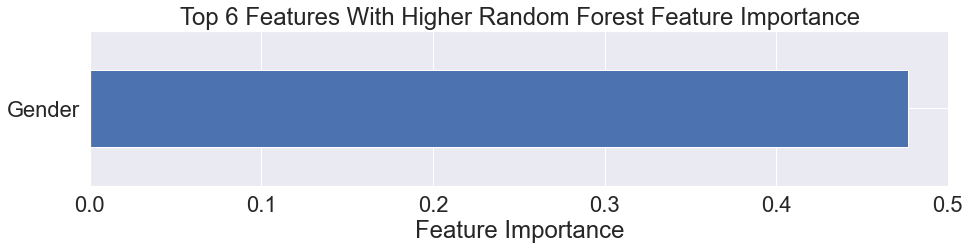

In [51]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFinal)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Yes  No
Actual Yes             47  52
No                     46  55

Accuracy:
51.0 %

Cross Validation Accuracy:
51.05 %

Classification Report:
              precision    recall  f1-score   support

         Yes       0.51      0.47      0.49        99
          No       0.51      0.54      0.53       101

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.51      0.51       200


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Yes  No
Actual Yes             48  51
No                     42  59

Accuracy:
53.5 %

Cross Validation Accuracy:
57.72 %

Classification Report:
              precision    recall  f1-score   support

         Yes       0.53      0.48      0.51        99
          No       0.54      0.58      0.56       101

    accuracy                           0.54       

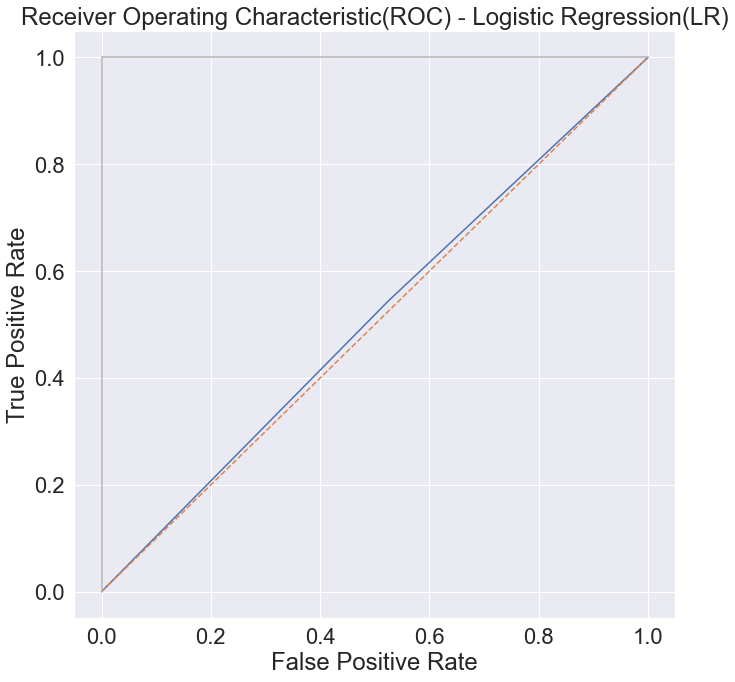

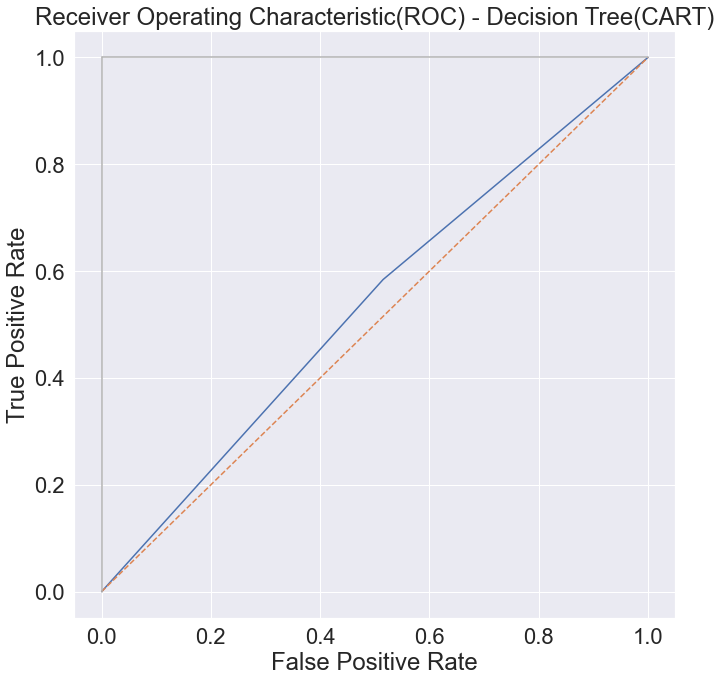

In [52]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

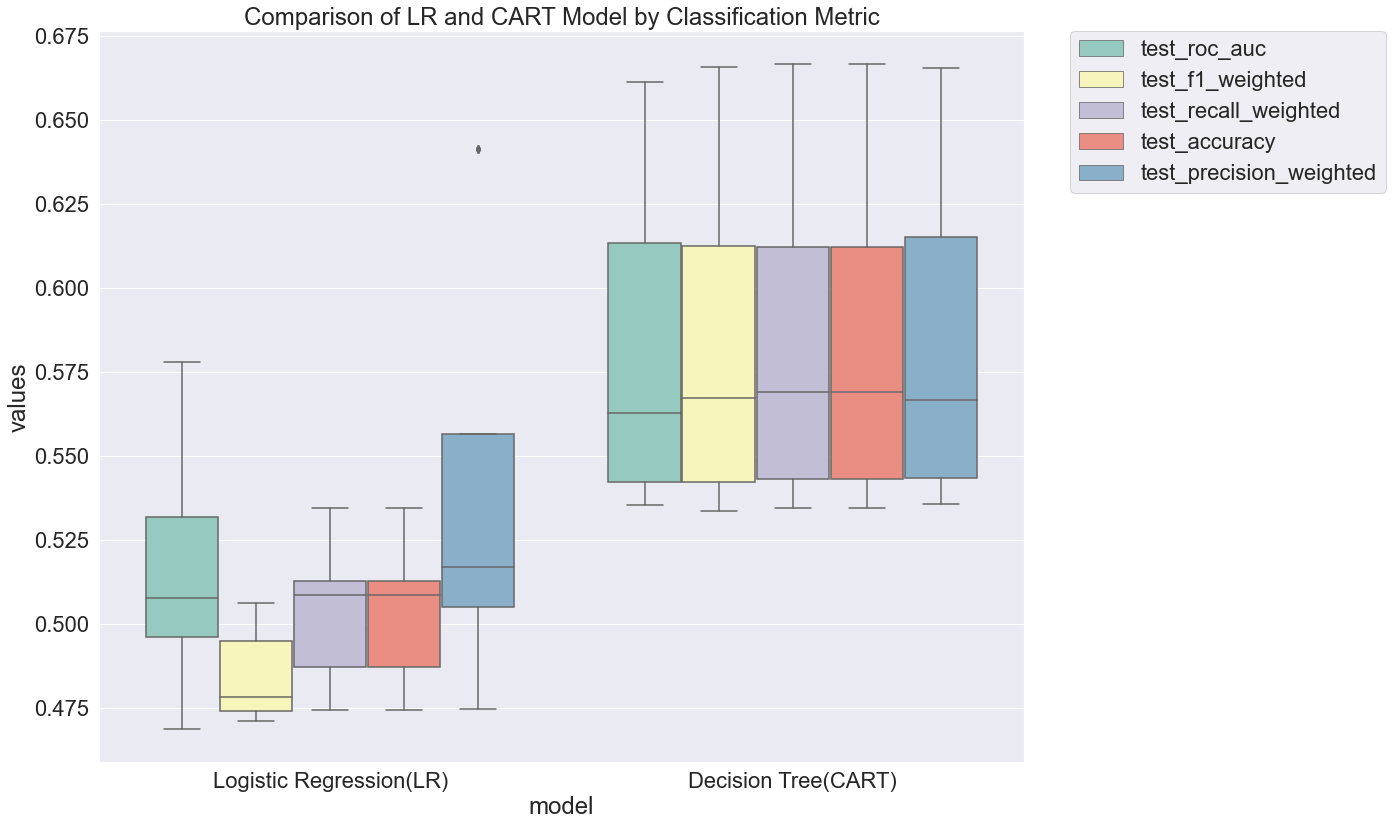

In [53]:
#Machine Learning models – Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [24]:
# Transform categorical / non-numeric columns into numerical columns
for column in dfFilter.columns:
        if dfFilter[column].dtype == 'object':
            dfFilter[column] = LabelEncoder().fit_transform(dfFilter[column])

In [34]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dfFilter)

In [147]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

silhouette_coefficients = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

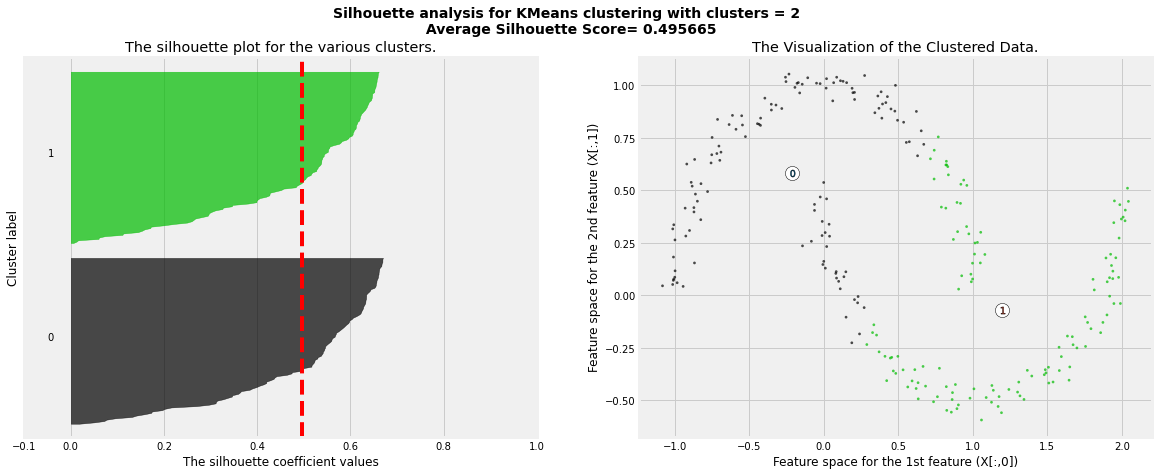

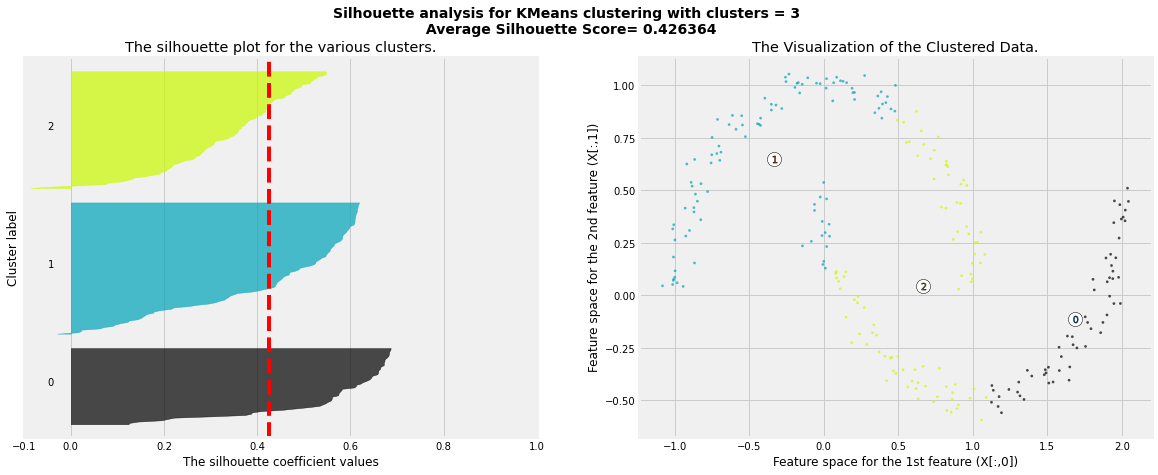

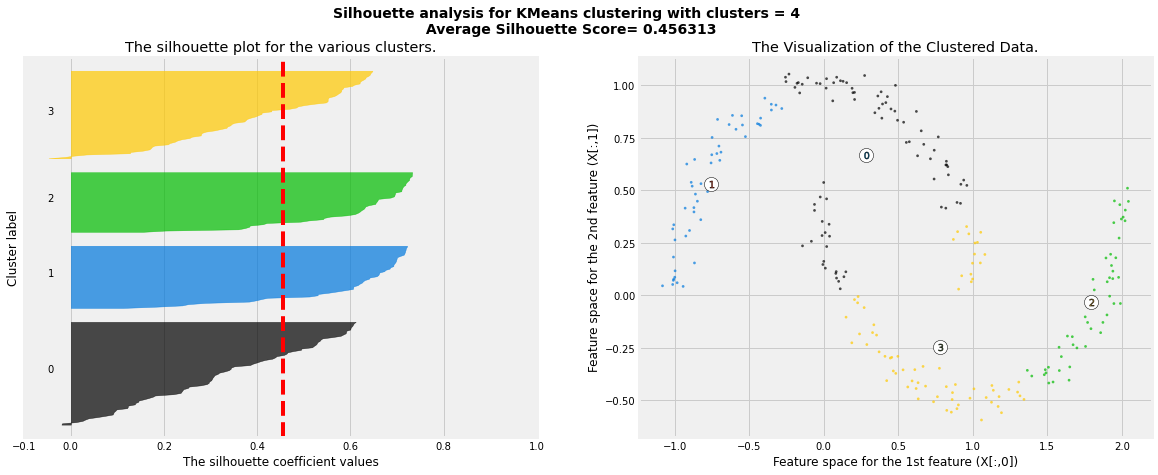

In [130]:
silhouetteplot.plot(dfFilter, [2, 3, 4])

In [155]:
silhouette_coefficients_medoid = []
for k in range(2, 5):
    kmedoids = KMedoids(k).fit(scaled_features)
    score = silhouette_score(scaled_features, kmedoids.labels_)
    silhouette_coefficients_medoid.append(score)

In [169]:
silhouette_coefficients_ahc = []
for k in range(2, 5):
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')

    cluster.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster.labels_)
    silhouette_coefficients_ahc.append(score.round(2))

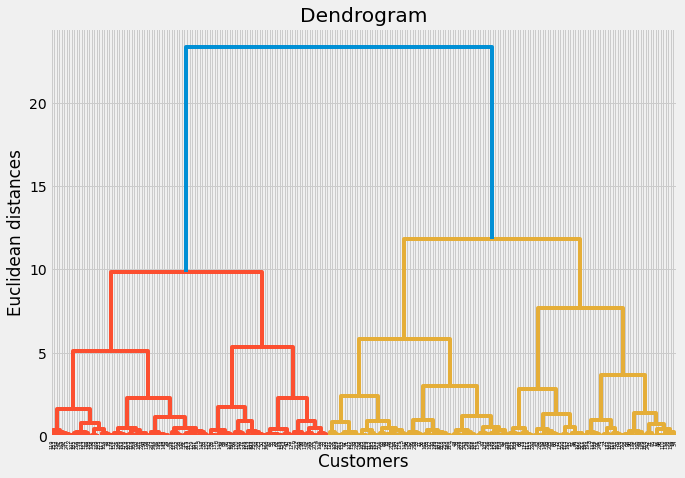

In [218]:
plt.figure(figsize=(10, 7))

dendrogram = sch.dendrogram(sch.linkage(scaled_features, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
plt.style.use("fivethirtyeight")
plt.subplot(1,3,1)
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient K-Means")

plt.style.use("fivethirtyeight")
plt.subplot(1,3,2)
plt.plot(range(2, 5), silhouette_coefficients_medoid)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient K-Medoid")

plt.style.use("fivethirtyeight")
plt.subplot(1,3,3)
plt.plot(range(2, 5), silhouette_coefficients_ahc)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient AHC")

# set the spacing between subplots
plt.subplots_adjust(left=1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=1,
                    hspace=1)

plt.show()

In [163]:
dfFilter, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42
)

In [164]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
kmedoids = KMedoids(n_clusters=2)
ahc = AgglomerativeClustering(n_clusters=2)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
kmedoids.fit(scaled_features)
ahc.fit_predict(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(3)
kmedoids_silhouette = silhouette_score(
   scaled_features, kmedoids.labels_
).round (3)
ahc_silhouette = silhouette_score(
   scaled_features, ahc.labels_
).round (3)

In [165]:
print(kmeans_silhouette)

print(kmedoids_silhouette)

print(ahc_silhouette)

0.497
0.473
0.457


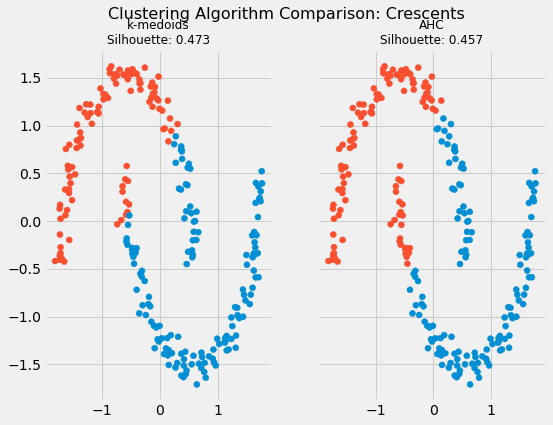

In [134]:
# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",
}
# The k-medoids plot
kd_colors = [fte_colors[label] for label in kmedoids.labels_]
ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=kd_colors)
ax1.set_title(
    f"k-medoids\nSilhouette: {kmedoids_silhouette}", fontdict={"fontsize": 12}
)

# The ahc plot
ahc_colors = [fte_colors[label] for label in ahc.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=ahc_colors)
ax2.set_title(
    f"AHC\nSilhouette: {ahc_silhouette}", fontdict={"fontsize": 12}
)
plt.show()

In [257]:
!pip install scipy